In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import sobel, gaussian_filter

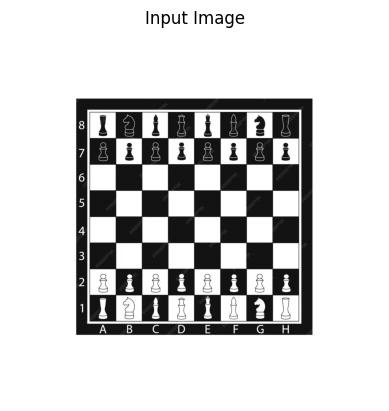

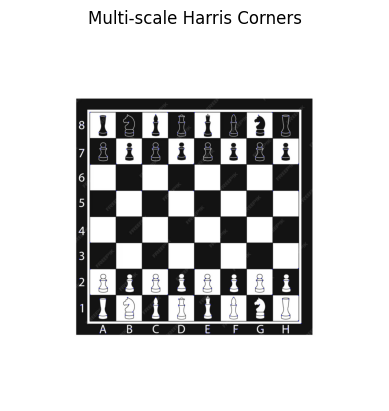

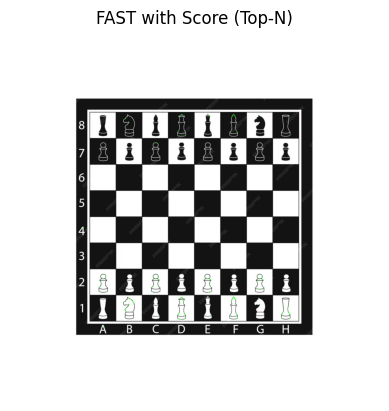

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import sobel, gaussian_filter, maximum_filter

# =========================
# Load Image
# =========================
image_path = "chess-board-with-chess-figures-black-white-vector-illustration_125869-1622.jpg"   # change path if needed
img = cv2.imread(image_path, 0)

if img is None:
    print("Image not found. Using synthetic image.")
    img = np.zeros((400,400), np.uint8)
    cv2.rectangle(img,(50,50),(150,150),255,2)
    cv2.rectangle(img,(200,200),(300,300),255,2)

plt.imshow(img, cmap="gray")
plt.title("Input Image")
plt.axis("off")
plt.show()

img = img.astype(np.float32)


# =========================
# Harris Response (efficient convolution)
# =========================
def harris_response(gray, sigma=1.5, k=0.04):
    Ix = sobel(gray, axis=1)
    Iy = sobel(gray, axis=0)

    Ixx = gaussian_filter(Ix*Ix, sigma)
    Iyy = gaussian_filter(Iy*Iy, sigma)
    Ixy = gaussian_filter(Ix*Iy, sigma)

    det = Ixx*Iyy - Ixy**2
    trace = Ixx + Iyy
    R = det - k*(trace**2)
    return R


# =========================
# Non-Max Suppression (radius parameter)
# =========================
def non_max_suppression(R, radius=5):
    max_filt = maximum_filter(R, size=2*radius+1)
    return (R == max_filt) & (R > 0)


# =========================
# Adaptive Threshold (percentile)
# =========================
def adaptive_threshold(R, percentile=99.5):
    Rpos = R[R > 0]
    if len(Rpos) == 0:
        return np.zeros_like(R, dtype=bool)
    thresh = np.percentile(Rpos, percentile)
    return R > thresh


# =========================
# Sub-pixel Refinement
# =========================
def subpixel_refine(R, y, x):
    window = R[y-1:y+2, x-1:x+2]

    dx = (window[1,2] - window[1,0]) / 2
    dy = (window[2,1] - window[0,1]) / 2

    dxx = window[1,2] - 2*window[1,1] + window[1,0]
    dyy = window[2,1] - 2*window[1,1] + window[0,1]

    offset_x = -dx/dxx if dxx != 0 else 0
    offset_y = -dy/dyy if dyy != 0 else 0

    return y + offset_y, x + offset_x


# =========================
# Multi-scale Harris
# =========================
def harris_multiscale(gray, sigmas=[1,2,4], top_n=200):
    all_points = []

    for sigma in sigmas:
        R = harris_response(gray, sigma)
        mask = adaptive_threshold(R)
        nms = non_max_suppression(R, radius=5)

        pts = np.argwhere(mask & nms)

        for y,x in pts:
            y2, x2 = subpixel_refine(R, y, x)
            all_points.append((y2, x2, R[y,x]))

    all_points.sort(key=lambda x: x[2], reverse=True)
    return all_points[:top_n]


# =========================
# FAST with Score (no overflow)
# =========================
circle = [(0,3),(1,3),(2,2),(3,1),(3,0),(3,-1),(2,-2),(1,-3),
          (0,-3),(-1,-3),(-2,-2),(-3,-1),(-3,0),(-3,1),(-2,2),(-1,3)]

def fast_detector(gray, threshold=25, n=12, top_n=200):
    gray = gray.astype(np.uint8)
    h,w = gray.shape
    points = []

    for y in range(3,h-3):
        for x in range(3,w-3):
            c = int(gray[y,x])
            cb = cd = 0
            mb = md = 0

            for dx,dy in circle:
                p = int(gray[y+dy, x+dx])

                if p > c + threshold:
                    cb += 1
                    cd = 0
                    mb = max(mb, cb)

                elif p < c - threshold:
                    cd += 1
                    cb = 0
                    md = max(md, cd)

                else:
                    cb = cd = 0

            if mb >= n or md >= n:
                score = 0
                for dx,dy in circle:
                    p = int(gray[y+dy, x+dx])
                    score += abs(p - c)

                points.append((y, x, score))

    points.sort(key=lambda x: x[2], reverse=True)
    return points[:top_n]


# =========================
# Run Harris Multi-scale
# =========================
harris_pts = harris_multiscale(img)

harris_out = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_GRAY2BGR)
for y,x,_ in harris_pts:
    cv2.circle(harris_out,(int(x),int(y)),2,(0,0,255),-1)

plt.imshow(harris_out)
plt.title("Multi-scale Harris Corners")
plt.axis("off")
plt.show()


# =========================
# Run FAST
# =========================
fast_pts = fast_detector(img.astype(np.uint8))

fast_out = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_GRAY2BGR)
for y,x,_ in fast_pts:
    cv2.circle(fast_out,(x,y),2,(0,255,0),-1)

plt.imshow(fast_out)
plt.title("FAST with Score (Top-N)")
plt.axis("off")
plt.show()

Running Harris Corner Detector (from scratch)...
Running FAST Corner Detector (from scratch)...


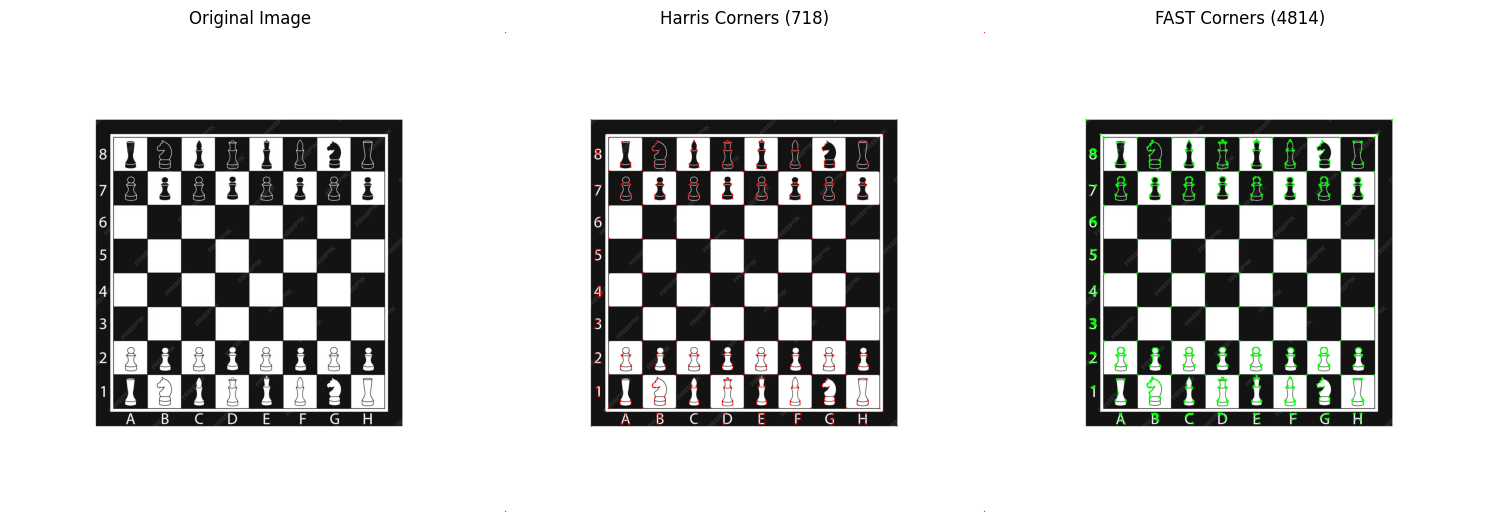

In [3]:
# feature_detectors.py
# Implementation of Harris Corner Detector and FAST Detector
# with detailed line-by-line comments for educational purposes
# Suitable for computer vision learning sessions

import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import sobel, gaussian_filter


# =============================================================================
#                          HARRIS CORNER DETECTOR
# =============================================================================

def harris_corners_from_scratch(gray_img, block_size=3, ksize=3, k=0.04, threshold_ratio=0.01):
    """
    Harris Corner Detector implemented from scratch using NumPy.
    Detects corners by analyzing intensity changes in two directions.
    
    Args:
        gray_img (np.ndarray): Grayscale image (2D array)
        block_size (int): Size of window for structure tensor summation
        ksize (int): Size of Sobel kernel
        k (float): Harris detector empirical constant (usually 0.04–0.06)
        threshold_ratio (float): Fraction of max response to consider as corner
    
    Returns:
        list[tuple]: List of (row, col) corner coordinates
    """
    # Step 1: Compute image gradients using Sobel operator
    Ix = sobel(gray_img, axis=1, mode='constant')          # Horizontal gradient
    Iy = sobel(gray_img, axis=0, mode='constant')          # Vertical gradient

    # Step 2: Compute products needed for structure tensor
    Ixx = Ix * Ix                                           # Ixx = Ix²
    Iyy = Iy * Iy                                           # Iyy = Iy²
    Ixy = Ix * Iy                                           # Ixy = Ix·Iy

    # Step 3: Apply Gaussian smoothing (helps reduce noise)
    # You can skip this or use uniform box filter instead
    Ixx = gaussian_filter(Ixx, sigma=1)                     # Smooth Ixx
    Iyy = gaussian_filter(Iyy, sigma=1)                     # Smooth Iyy
    Ixy = gaussian_filter(Ixy, sigma=1)                     # Smooth Ixy

    # Step 4: Compute structure tensor elements using summation over window
    Sxx = np.zeros_like(gray_img, dtype=np.float32)         # Sum of Ixx in window
    Syy = np.zeros_like(gray_img, dtype=np.float32)         # Sum of Iyy in window
    Sxy = np.zeros_like(gray_img, dtype=np.float32)         # Sum of Ixy in window

    half = block_size // 2
    for y in range(half, gray_img.shape[0] - half):
        for x in range(half, gray_img.shape[1] - half):
            window_xx = Ixx[y-half:y+half+1, x-half:x+half+1]
            window_yy = Iyy[y-half:y+half+1, x-half:x+half+1]
            window_xy = Ixy[y-half:y+half+1, x-half:x+half+1]
            Sxx[y, x] = np.sum(window_xx)                   # Sum over neighborhood
            Syy[y, x] = np.sum(window_yy)
            Sxy[y, x] = np.sum(window_xy)

    # Step 5: Compute Harris response function
    det_M  = Sxx * Syy - Sxy * Sxy                          # det(M) = λ₁λ₂
    trace_M = Sxx + Syy                                     # trace(M) = λ₁ + λ₂
    R = det_M - k * (trace_M ** 2)                          # Harris corner measure

    # Step 6: Find strong corner responses
    max_response = np.max(R)                                # Find global maximum response
    corner_mask = R > threshold_ratio * max_response        # Thresholding

    # Step 7: Simple non-maximum suppression (keep local maxima)
    corners = []
    for y in range(1, R.shape[0]-1):
        for x in range(1, R.shape[1]-1):
            if corner_mask[y, x]:
                # Check 3×3 neighborhood
                neighborhood = R[y-1:y+2, x-1:x+2]
                if R[y, x] == np.max(neighborhood):
                    corners.append((y, x))                      # Valid corner

    return corners


# =============================================================================
#                               FAST DETECTOR
# =============================================================================

def fast_corners_from_scratch(gray_img, threshold=25, n=12):
    """
    Basic FAST (Features from Accelerated Segment Test) corner detector.
    Very fast because it uses simple pixel intensity comparisons.
    
    Args:
        gray_img (np.ndarray): Grayscale image (uint8 recommended)
        threshold (int): Intensity difference to consider brighter/darker
        n (int): Minimum number of contiguous pixels in the circle (usually 9 or 12)
    
    Returns:
        list[tuple]: List of (row, col) corner coordinates
    """
    if gray_img.dtype != np.uint8:
        gray_img = gray_img.astype(np.uint8)

    height, width = gray_img.shape
    corners = []

    # Bresenham circle of radius 3 → 16 pixels
    circle = [
        (0, 3), (1, 3), (2, 2), (3, 1), (3, 0), (3, -1), (2, -2), (1, -3),
        (0, -3), (-1, -3), (-2, -2), (-3, -1), (-3, 0), (-3, 1), (-2, 2), (-1, 3)
    ]

    for y in range(3, height - 3):
        for x in range(3, width - 3):
            center = int(gray_img[y, x])                    # Center pixel intensity

            brighter = 0
            darker   = 0
            consec_bright = 0
            consec_dark   = 0
            max_consec_b = 0
            max_consec_d = 0

            for dx, dy in circle:
                p = int(gray_img[y + dy, x + dx])           # Neighbor pixel

                if p > center + threshold:
                    brighter += 1
                    consec_bright += 1
                    consec_dark = 0
                    max_consec_b = max(max_consec_b, consec_bright)
                elif p < center - threshold:
                    darker += 1
                    consec_dark += 1
                    consec_bright = 0
                    max_consec_d = max(max_consec_d, consec_dark)
                else:
                    consec_bright = 0
                    consec_dark   = 0

            # If we have enough contiguous brighter OR darker pixels → corner
            if max_consec_b >= n or max_consec_d >= n:
                corners.append((y, x))

    return corners


# =============================================================================
#                               DEMONSTRATION
# =============================================================================

def main():
    # Load example image (replace with your own path)
    img_path = "chess-board-with-chess-figures-black-white-vector-illustration_125869-1622.jpg" # Use an image with clear corners
    #img_path = "sudoku.jpg"
    #img_path = "building.jpg"

    original = cv2.imread(img_path)
    if original is None:
        print("Error: Could not load image. Please check the file path.")
        return

    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)       # Convert to grayscale

    # ------------------- Harris -------------------
    print("Running Harris Corner Detector (from scratch)...")
    harris_pts = harris_corners_from_scratch(gray.astype(np.float32),
                                             block_size=3, ksize=3, k=0.04,
                                             threshold_ratio=0.01)

    # ------------------- FAST ---------------------
    print("Running FAST Corner Detector (from scratch)...")
    fast_pts = fast_corners_from_scratch(gray, threshold=30, n=9)

    # Visualization
    img_harris = original.copy()
    for y, x in harris_pts:
        cv2.circle(img_harris, (x, y), 3, (0, 0, 255), -1)  # Red circles

    img_fast = original.copy()
    for y, x in fast_pts:
        cv2.circle(img_fast, (x, y), 3, (0, 255, 0), -1)    # Green circles

    # Show results
    plt.figure(figsize=(15, 8))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(img_harris, cv2.COLOR_BGR2RGB))
    plt.title(f"Harris Corners ({len(harris_pts)})")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(img_fast, cv2.COLOR_BGR2RGB))
    plt.title(f"FAST Corners ({len(fast_pts)})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()
